In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import os
import cv2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [3]:
img_size = 32

def loading_data(path,label):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            data.append([label, img_resize])
        except Exception as e:
            pass
    return np.array(data, dtype=object)


In [6]:
Real_path = "C:/Users/marve/Vidhyuth/Programming/Datasets/Fingerprint_images/SOCOFing/Real"
Easy_path = "C:/Users/marve/Vidhyuth/Programming/Datasets/Fingerprint_images/SOCOFing/Altered-Easy"
Medium_path="C:/Users/marve/Vidhyuth/Programming/Datasets/Fingerprint_images/SOCOFing/Altered-Medium"
Hard_path = "C:/Users/marve/Vidhyuth/Programming/Datasets/Fingerprint_images/SOCOFing/Altered-Hard"

Easy_data = loading_data(Easy_path,0)
Medium_data = loading_data(Medium_path,0)
Hard_data = loading_data(Hard_path,0)
real_data = loading_data(Real_path,1)

fake_data = np.concatenate([Easy_data,Medium_data,Hard_data],axis=0)
del Easy_data, Medium_data, Hard_data

loading data from:  C:/Users/marve/Vidhyuth/Programming/Datasets/Fingerprint_images/SOCOFing/Altered-Easy
loading data from:  C:/Users/marve/Vidhyuth/Programming/Datasets/Fingerprint_images/SOCOFing/Altered-Medium
loading data from:  C:/Users/marve/Vidhyuth/Programming/Datasets/Fingerprint_images/SOCOFing/Altered-Hard
loading data from:  C:/Users/marve/Vidhyuth/Programming/Datasets/Fingerprint_images/SOCOFing/Real


In [7]:
# Separate labels and images
real_labels, real_images = real_data[:, 0], real_data[:, 1]
fake_labels, fake_images = fake_data[:, 0], fake_data[:, 1]

# Reshape and normalize images
real_images = np.array([img.reshape(img_size, img_size, 1) for img in real_images]) / 255.0
fake_images = np.array([img.reshape(img_size, img_size, 1) for img in fake_images]) / 255.0

In [8]:
# Create ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Calculate how many augmented real images we need
num_fake = len(fake_images)
num_real = len(real_images)
num_augmented_needed = num_fake - num_real
print(num_augmented_needed)

43270


In [13]:
# Generate augmented real images
augmented_real_images = []
augmented_real_labels = []

for x_batch, y_batch in datagen.flow(real_images, real_labels, batch_size=32):
    augmented_real_images.extend(x_batch)
    augmented_real_labels.extend(y_batch)
    if len(augmented_real_images) >= num_augmented_needed:
        break

augmented_real_images = np.array(augmented_real_images[:num_augmented_needed])
augmented_real_labels = np.array(augmented_real_labels[:num_augmented_needed])

# Combine original and augmented real images, and all fake images
all_images = np.concatenate([real_images, augmented_real_images, fake_images], axis=0)
all_labels = np.concatenate([real_labels, augmented_real_labels, fake_labels], axis=0)

In [24]:
np.concatenate([real_images, augmented_real_images], axis=0).shape

(49270, 32, 32, 1)

In [25]:
fake_images.shape

(49270, 32, 32, 1)

In [32]:
np.unique(all_labels, return_counts=True)

(array([0, 1], dtype=object), array([49270, 49270], dtype=int64))

In [15]:
# Shuffle the data
indices = np.arange(len(all_images))
np.random.shuffle(indices)
all_images = all_images[indices]
all_labels = all_labels[indices]

# Convert labels to categorical
from tensorflow.keras.utils import to_categorical
all_labels_categorical = to_categorical(all_labels, num_classes=2)

In [16]:
# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels_categorical, test_size=0.2, random_state=42)

In [47]:
model = Sequential([
                    Conv2D(32, 3, padding='same', activation='relu',input_shape = [img_size,img_size, 1]),
                    MaxPooling2D(2),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D(2),
                    Flatten(),
                    Dense(128,activation = 'relu'),
                    Dropout(0.4),
                    Dense(2, activation = 'softmax'),
                    ])
model.summary()
model.compile(optimizer = optimizers.Adam(1e-3), 
              loss =tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_7 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                      

In [48]:
history = model.fit(X_train,y_train, epochs=5, 
                    validation_data=[X_val,y_val], 
                    callbacks=[early_stopping_cb], verbose=1)

Epoch 1/5
2464/2464 [==============================] - 22s 8ms/step - loss: 0.1659 - accuracy: 0.9369 - val_loss: 0.1390 - val_accuracy: 0.9371
Epoch 2/5
2464/2464 [==============================] - 20s 8ms/step - loss: 0.1407 - accuracy: 0.9383 - val_loss: 0.1330 - val_accuracy: 0.9383
Epoch 3/5
2464/2464 [==============================] - 22s 9ms/step - loss: 0.1300 - accuracy: 0.9392 - val_loss: 0.1406 - val_accuracy: 0.9377
Epoch 4/5
2464/2464 [==============================] - 21s 9ms/step - loss: 0.1243 - accuracy: 0.9411 - val_loss: 0.1223 - val_accuracy: 0.9406
Epoch 5/5
2464/2464 [==============================] - 21s 8ms/step - loss: 0.1199 - accuracy: 0.9424 - val_loss: 0.1239 - val_accuracy: 0.9393


(0.0, 1.0)

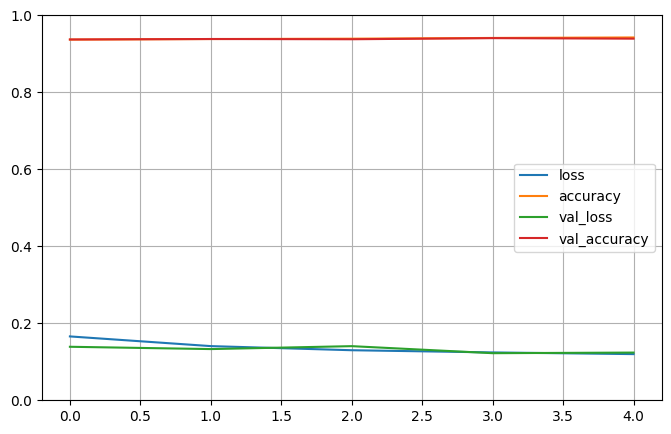

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

616/616 [==============================] - 2s 3ms/step


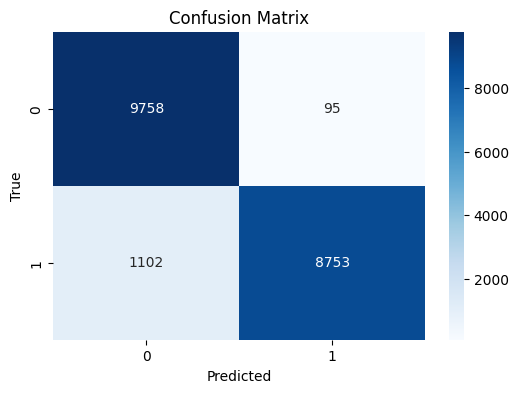

              precision    recall  f1-score   support

        Fake       0.90      0.99      0.94      9853
        Real       0.99      0.89      0.94      9855

    accuracy                           0.94     19708
   macro avg       0.94      0.94      0.94     19708
weighted avg       0.94      0.94      0.94     19708



In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=['Fake', 'Real']))

1/1 [==============================] - 0s 34ms/step
Predicted class: Altered
Confidence: 1.00


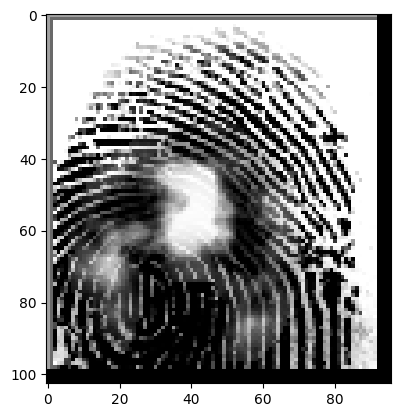

In [55]:
def preprocess_image(img_path):
    img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resize = cv2.resize(img_array, (img_size, img_size))
    img_normalized = img_resize / 255.0
    return img_normalized.reshape(-1, img_size, img_size, 1)

# Path to your random fingerprint image
random_img_path = r"C:\Users\marve\Vidhyuth\Programming\Datasets\Fingerprint_images\SOCOFing\Altered-Hard\1__M_Right_index_finger_Obl.BMP"
plt.imshow(cv2.imread(random_img_path))
# Preprocess the image
input_image = preprocess_image(random_img_path)
prediction = model.predict(input_image)
# Interpret the prediction
class_names = ['Altered', 'Real']
predicted_class = class_names[np.argmax(prediction[0])]
confidence = np.max(prediction)

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")